In [63]:
#------------------------------------------------------------
#	Library
#------------------------------------------------------------
# Built-in packages
import os
import sys
import re
import time
import glob
import json
from pathlib import Path
from datetime import datetime, timezone, timedelta
from itertools import repeat
import subprocess
import multiprocessing
import warnings
warnings.filterwarnings(action='ignore')
#------------------------------------------------------------
# Third-party packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.core.interactiveshell import InteractiveShell
from ccdproc import ImageFileCollection
import psutil
#	Astropy
from astropy.io import fits
import astropy.io.ascii as ascii
from astropy import units as u
from astropy.table import Table, vstack, hstack, unique
from astropy.coordinates import SkyCoord
from astropy.time import Time

In [64]:
def is_within_ellipse(ra_obj, dec_obj, ra_center, dec_center, 
                      delta_ra=0.01667, delta_dec=0.01667, 
                      a=1.45/2, b=0.65/2, theta_deg=10):
    """
    천체가 주어진 타원 내부에 있는지 여부를 반환하는 함수

    Parameters:
    ra_obj, dec_obj: 천체의 RA 및 Dec 좌표 (deg)
    ra_center, dec_center: 타원의 중심 RA 및 Dec 좌표 (deg)
    delta_ra, delta_dec: 포인팅 오차 (deg), 기본값은 1'
    a, b: 타원의 장축 및 단축 반경 (deg), 기본값은 대각선 길이에 기반한 값
    theta_deg: 타원의 회전 각도 (deg), 기본값은 10도

    Returns:
    True: 천체가 타원 내부에 포함됨
    False: 천체가 타원 외부에 있음
    """
    # 타원의 중심 좌표를 오차를 적용하여 이동
    ra_center = ra_center + delta_ra
    dec_center = dec_center + delta_dec
    
    # 천체와 타원 중심 간의 좌표 차이
    ra_diff = (ra_obj - ra_center) * np.cos(np.deg2rad(dec_center))  # 적경 차이 고려
    dec_diff = dec_obj - dec_center
    
    # 회전 각도(rad)
    theta = np.deg2rad(theta_deg)
    
    # 회전 변환 적용
    x_prime = ra_diff * np.cos(theta) + dec_diff * np.sin(theta)
    y_prime = -ra_diff * np.sin(theta) + dec_diff * np.cos(theta)
    
    # 타원의 방정식에 따른 계산
    ellipse_eq = (x_prime**2 / a**2) + (y_prime**2 / b**2)
    
    # 타원의 내부에 있으면 True, 아니면 False 반환
    return ellipse_eq <= 1

In [65]:
path_skygrid = '/large_data/factory/skygrid'
path_ks4 = '/large_data/factory/ref_scamp/KS4_gaia_cat'
path_out = '/large_data/factory/ref_scamp'

In [93]:
ntile = 'T01000'
path_tmp = f'/large_data/processed_1x1_gain2750/{ntile}/*/m650/phot'
photbl = Table.read(glob.glob(f"{path_tmp}/calib*m650*.com.phot.cat")[0], format='ascii')

In [94]:
r_match = 2.5 # [deg]
# delta_ra = 0.01667
# delta_dec = 0.01667
delta_ra = 0.01
delta_dec = 0.0
a = 1.4 / 1
b = 1.0 / 1
theta_deg = 0


In [95]:
ks4tbl = Table.read(f"{path_ks4}/kmtnet_grid.fits")
c_ks4 = SkyCoord(ks4tbl['ra[deg]'], ks4tbl['dec[deg]'], unit='deg')
ks4tbl[:3]

field_name1,field_name2,ra[deg],dec[deg],ra[hms],dec[hms],gl[deg],gb[deg],max_dith
int64,bytes6,float64,float64,bytes11,bytes12,float64,float64,float64
0,000-62,0.0,-62.0,00:00:00.00,-62:00:00.00,313.3222229948697,-53.94578530148613,4.0
1,004-62,4.090909004211426,-62.0,00:16:21.82,-62:00:00.00,310.1804895954569,-54.50700602255747,4.0
2,008-62,8.181818008422852,-62.0,00:32:43.64,-62:00:00.00,306.9167653962037,-54.86593364391395,4.0


In [96]:
sdtbl = Table.read(f"{path_skygrid}/skygrid_tiles_7DS.csv")
c_7dt = SkyCoord(sdtbl['ra'], sdtbl['dec'], unit='deg')
sdtbl[:3]

#id,ra,dec,tile
int64,float64,float64,str6
0,0.0,-90.0,T00000
1,0.0,-89.15094339622642,T00001
2,51.42857142857143,-89.15094339622642,T00002


In [97]:
for ii, c in enumerate(c_7dt[int(ntile[1:]):]):
	print(c)
	sep = c.separation(c_ks4)
	reftablelist = []

	select_ks4tbl = ks4tbl[sep.deg < r_match]
	print(f"{len(select_ks4tbl)} tables selected")

	for refnumb in select_ks4tbl['field_name1'].data:
		tablename = f"{path_ks4}/refcat{refnumb}.fits"
		if os.path.exists(tablename):
			part_reftbl = Table.read(tablename)
			reftablelist.append(part_reftbl)
		else:
			print(f"{tablename} not found")

	areftbl = unique(vstack(reftablelist))
	# c_ref = SkyCoord(areftbl['RAJ2000'], areftbl['DEJ2000'], unit='deg')
	print(f"{len(areftbl):_} rows stacked")

	break


<SkyCoord (ICRS): (ra, dec) in deg
    (351.81818182, -72.16981132)>
6 tables selected
354_533 rows stacked


55_782 Gaia sources found


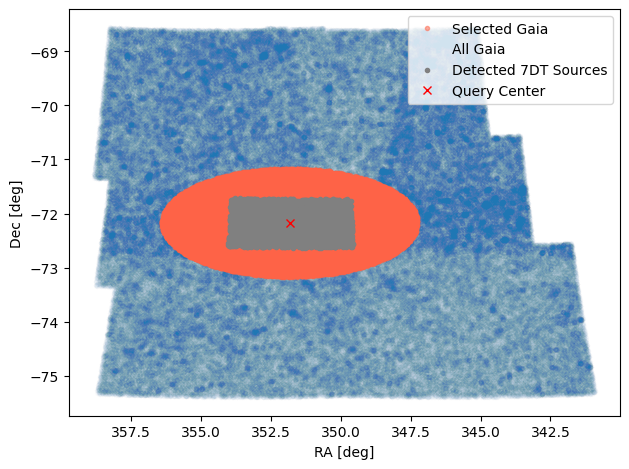

In [98]:
is_inside = is_within_ellipse(
	ra_obj=areftbl['RAJ2000'], dec_obj=areftbl['DEJ2000'], 
	ra_center=c.ra.deg, dec_center=c.dec.deg,
	delta_ra=delta_ra, delta_dec=delta_dec, 
	a=a, b=b, theta_deg=theta_deg
	)

reftbl = areftbl[is_inside]
c_ref = SkyCoord(reftbl['RAJ2000'], reftbl['DEJ2000'], unit='deg')

plt.plot(reftbl['RAJ2000'], reftbl['DEJ2000'], '.', color='tomato', alpha=0.5, label='Selected Gaia')
plt.plot(areftbl['RAJ2000'], areftbl['DEJ2000'], '.', alpha=0.01, zorder=0, label='All Gaia')
plt.plot(photbl['ALPHA_J2000'], photbl['DELTA_J2000'], '.', color='grey', label='Detected 7DT Sources')
plt.plot(c.ra.deg, c.dec.deg, 'rx', zorder=999, label='Query Center')

plt.legend()
xl, xr = plt.xlim()
plt.xlim(xr, xl)
plt.xlabel("RA [deg]")
plt.ylabel("Dec [deg]")
plt.tight_layout()


print(f"{len(reftbl):_} Gaia sources found")